In [271]:
### Allen B Davis
### Yale University
###
### First year project
### Summer 2015

# RVOS_Kepler will create RV observations of a star with one planet, create a periodogram with FAP,
# fit a Keplerian, and return uncertainties in the planet's mass and orbital parameters

In [272]:
# Imports
import sys
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.signal
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
import pickle
from lmfit import minimize, Parameters, Parameter, report_fit
from time import strftime
import os
import errno


%matplotlib inline

try:
    rvos_title_file = open('title_art.txt', 'r')
    rvos_str = rvos_title_file.read()
    rvos_title_file.close()
except IOError:
    pass

plt.close()

In [273]:
# Constants

### Constants, all in SI unless otherwise specified
mEarth = 5.97219E24
mJup = 1.898E27 
mSun = 1.9891E30 
G = 6.67384E-11
au = 149597870700. 
day = 86400.
year = 365.256363004*day
pi = math.pi
today = 2457182.36553 #JD

In [274]:
#Eventually make a Star class that calls Planet classes.

class Star:
    def __init__(self,massStar,t0,coord,planets=None,name=''):
        self.typecheck = 'Star'
        self.massStar = massStar #in mSun. Default: 1 solar mass
        self.name = name
        self.t0 = t0 #nominal start date of observations
        self.coord = coord #ra/dec position on the sky
        if not planets == None:
            self.planets = planets
        
class Planet:
    
    def __init__(self,star,mass,period,ecc,incl,w,tp,K=None,isReal=True):
        self.typecheck = 'Planet'
        self.isReal = isReal
        self.star = star
        self.name = star.name #initialized to star's name. Will append letter later.
        self.mass = mass #in mEarth
        self.period = period #in years
        self.massStar = star.massStar #in mSun. Default: 1 solar mass
        self.ecc = ecc #eccentricity. Default: 0.2
        self.incl = incl #inclination in degrees. Default: 90.
        self.sini = np.sin(incl*pi/180.) #sin(i)
        self.t0 = star.t0 #JD of start. default: "today"

        def getSMA():
            totmass = (self.mass*mEarth)+(star.massStar*mSun)
            return (1/au) * ( ( (self.period*year)**2 * G*totmass ) / ( 4.*pi*pi))**(1./3.)
        
        self.sma = getSMA() #semimajor axis in AU. Given uniquely by mass, massStar, and period.
        
        if w==None:
            self.w = 2.*pi*np.random.random() #phase. default: random phase from [0,2pi)
        else:
            self.w = w
        
        if tp==None:
            self.tp = self.t0+(np.random.random()*self.period) #periastron time. Default: random from [today,today+period)
        else:
            self.tp = tp
            
        if K == None:
            self.K = (2.*pi*G/(self.period*day))**(1./3.) * (self.mass*mEarth*self.sini) * ((self.massStar*mSun)**(-2./3.)) * (1./np.sqrt(1.-self.ecc**2.))
        else:
            self.K = K #used for a fitted planet, where the K is known but the mass is actually just msini
        self.params = [self.period,self.ecc,self.tp,self.w,self.K,self.mass]
        self.params_print = [self.period,self.ecc,self.tp-self.t0,self.w*180./pi,self.K,self.mass]
        


In [275]:
def observe_star(star,ndays,std_True,t0_in,coord,loc,t_res,objAltThres,weather):

    planets = star.planets
    n_pls = np.size(planets)

    t0 = Time(t0_in,format='jd')
    
    t = t0 #the day considered in each loop
    sep = 1.*u.day
    obsList = []
    
    attempted_obs = 0
    
    def pickingLoop(obsList,t,attempted_obs,sep,ndays,flag1=True,flag2=True):
        while (attempted_obs < ndays) and (flag1 or np.size(obsList) < 5) and (flag2 or np.size(obsList) < 10):
            nextObsTime = pickObsTime(coord,loc,t,t_res,objAltThres)
            todaysweather = np.random.random() #how's it looking tonight?
            
            if todaysweather < weather: #it's clear; let's observe!
                obsList = np.append(obsList,nextObsTime)
            
            t = nextObsTime + sep
            attempted_obs += 1
        return obsList,t,attempted_obs
    
    # Start with ~1 day separation between observations
    obsList,t,attempted_obs = pickingLoop(obsList,t,attempted_obs,sep,ndays,flag1=False)
    
    # Now decide whether to use a longer spacing
    if scatter(star,obsList) > std_True: # Keep a separation of 1 day
        obsList,t,attempted_obs = pickingLoop(obsList,t,attempted_obs,sep,ndays) 

    else: # Ramp it up to 5 day separation
        sep = 5.*u.day
        obsList,t,attempted_obs = pickingLoop(obsList,t,attempted_obs,sep,ndays,flag2=False)  
        
        # Reevaluate whether the separation must again be increased
        if scatter(star,obsList) > std_True: # Keep a 5 day separation
            obsList,t,attempted_obs = pickingLoop(obsList,t,attempted_obs,sep,ndays)
            
        else: # Ramp it up to 10 day separation and keep it there
            sep = 10.*u.day
            obsList,t,attempted_obs = pickingLoop(obsList,t,attempted_obs,sep,ndays)

    # Save the obsList
    star.obsList_units = obsList #in terms of astropy units
    star.obsList = removeUnits(obsList) #simple JD values

    # Record true RV curve
    RVs = [None]*n_pls
    for i in range(0,n_pls):
        p = planets[i]
        f = calcTrueAnomaly(p.period,p.tp,p.ecc,removeUnits(obsList))
        RVs[i] = p.K*(np.cos(p.w+f) + p.ecc*np.cos(p.w))
        p.RV_True = RVs[i] #also save each individual planet's RV
        
    RV = np.sum(RVs,axis=0) #sum each planet's RV contribution
    star.RV_True = RV
    
    #add jitter scaled to a normal distribution
    errList = np.random.normal(0, std_True, np.size(star.obsList))

    #record observed RV curve
    star.RV_Obs = star.RV_True + errList

    #record observated scatter in RV curve
    star.std_Obs = np.std(star.RV_Obs)
    


# Calculates all the possible times a star will be above an altitude and returns a random time
# to observe it while the sun is down
def pickObsTime(coord,loc,t,t_res,objAltThres,sunAltThres=-18.):
    #coord is SkyCoord object; loc is EarthLocation object; t0 is Time object
    #t_res is time resolution in minutes. Suggest 5 or 10 minutes
    
    delta_t = np.linspace(0,24,24*60./t_res)*u.hour #divides a day into 5-minute chunks
    timeRange = t+delta_t
        
    altazframe = AltAz(obstime=timeRange, location=loc)
    sunaltazs = get_sun(timeRange).transform_to(altazframe)
    objaltazs = coord.transform_to(altazframe)
    
    sunDownTimes = delta_t[np.where(sunaltazs.alt < sunAltThres*u.deg)]
    objUpTimes = delta_t[np.where(objaltazs.alt > objAltThres*u.deg)]

    sunBools = sunaltazs.alt < sunAltThres*u.deg #True/False arrays
    objBools = objaltazs.alt > objAltThres*u.deg
    
    goodoffsets = delta_t[sunBools*objBools]
    size = np.size(goodoffsets)
    
    if size == 0:
        return pickObsTime(coord,loc,findNextOpportunity(t,coord,loc,t_res,objAltThres),
                           t_res,objAltThres)
    else:
        goodtimes = t+goodoffsets #picks out the times that satisfy both conditions
        return goodtimes[np.random.randint(0,size)]

    
#returns the date when the object will next be good to observe
def findNextOpportunity(t,coord,loc,t_res,objAltThres):
    start = t
    end = start + 1.*u.year
    found = False
    while start <= end and not found:
        midpoint = Time((start.value+end.value)/2,format='jd')
        if isGood(midpoint,coord,loc,t_res,objAltThres): 
            end = midpoint
            if not isGood(midpoint-1*u.day,coord,loc,t_res,objAltThres):
                found = True
                return midpoint
        else:
            start = midpoint + 1*u.day
    return midpoint


# tests whether the object is good to observe on a certain JD
def isGood(t,coord,loc,t_res,objAltThres,sunAltThres=-18.):
    delta_t = np.linspace(0,24,24*60./t_res)*u.hour #divides a day into 5-minute chunks
    timeRange = t+delta_t

    altazframe = AltAz(obstime=timeRange, location=loc)
    sunaltazs = get_sun(timeRange).transform_to(altazframe)
    objaltazs = coord.transform_to(altazframe)

    sunDownTimes = delta_t[np.where(sunaltazs.alt < sunAltThres*u.deg)]
    objUpTimes = delta_t[np.where(objaltazs.alt > objAltThres*u.deg)]

    sunBools = sunaltazs.alt < sunAltThres*u.deg #True/False arrays
    objBools = objaltazs.alt > objAltThres*u.deg

    goodoffsets = delta_t[sunBools*objBools]
    size = np.size(goodoffsets)

    return not size == 0


In [276]:
def scatter(star,obsList):
    planets = star.planets
    n_pls = np.size(planets)
    
    RVs = [None]*n_pls
    #find the RV contribution of each planet independently
    for i in range(0,n_pls):
        p = planets[i]
        f = calcTrueAnomaly(p.period,p.tp,p.ecc,removeUnits(obsList))
        RVs[i] = p.K*(np.cos(p.w+f) + p.ecc*np.cos(p.w))
    
    RV = np.sum(RVs,axis=0) #sum each planet's RV contribution
    return np.std(RV)


def removeUnits(arr_in):
    if not isinstance(arr_in[0],float):
        arr = np.array(arr_in[0].value)
        for elem in arr_in[1:]:
            arr = np.append(arr,elem.value)
    return arr


def saveParams(sim,saveSim=False):
    #FIX FOR MULTIPLE PLANETS
    p = sim.planet
    
    # Planet's parameters
    inj_str = ("\nInjected parameters:\nPeriod = {0:.4f} days\nEccentricity = {1:.3f}"
              "\nPeriastron Time = {2:.3f} (days-t0)\nArgument of Periastron = {3:.2f} deg"
              "\nSemiamplitude = {4:.2f} m/s\nMass = {5:.2f} M_e").format(*p.params_print)
    fit_str = ("\nFitted parameters:\nPeriod = {0:.4f} days\nEccentricity = {1:.3f}"
              "\nPeriastron Time = {2:.3f} (days-t0)\nArgument of Periastron = {3:.2f} deg"
              "\nSemiamplitude = {4:.2f} m/s\nMsini = {5:.2f} M_e").format(*p.params_out_print)
    if sim.find_uncs:
        unc_str = ("\n1-sigma uncertainties:\nPeriod = {0:.4f} days\nEccentricity = {1:.3f}"
                  "\nPeriastron Time = {2:.3f} (days-t0)\nArgument of Periastron = {3:.2f} rad"
                  "\nSemiamplitude = {4:.2f} m/s\nMsini = {5:.2f} M_e").format(*p.uncs)
            
    # Print, if requested (default)
    if sim.verbose:
        print inj_str
        print fit_str
        if sim.find_uncs: print unc_str
        sys.stdout.flush()
        
    # Save to text file if requested
    if sim.saveObs:
    
        f = open(sim.saveObs+'_'+sim.theTime+'.txt','w')

        f.write(inj_str+'\n'+fit_str+'\n')
        if sim.find_uncs:
            f.write(unc_str+'\n')

        f.write('-------------------\n')
        f.write('JD,RV_True,RV_Obs\n')
        for i in range(0,np.size(p.RV_Obs)):
            f.write(str(p.obsList[i])+','+str(p.RV_True[i])+','+str(p.RV_Obs[i])+'\n')
        
    
    # Save the sim to a pickle
    if saveSim:
        fpkl = open('sim_'+sim.theDate+'_'+sim.theTime+'.pkl','w')
        pickle.dump(sim,fpkl)

In [277]:
# Calculates the true anomaly from the time and orbital elements.
def calcTrueAnomaly(P, tp, e, t):

    phase = (t-tp)/P #phase at each obsList time
    M = 2.*pi*(phase - np.floor(phase)) #Mean Anom array: at each obsList time
    E1 = calcKepler(M, np.array([e]))

    n1 = 1. + e
    n2 = 1. - e

    #True Anomaly:
    return 2.*np.arctan(np.sqrt(n1/n2)*np.tan(E1/2.))


#returns Eccentric anomaly, given mean anomaly and eccentricity
def calcKepler(Marr_in, eccarr_in):


    nm = np.size(Marr_in)
    nec = np.size(eccarr_in)

    if nec == 1 and nm > 1:
        eccarr = eccarr_in #[eccarr_in for x in range(nm)]
    else:
        eccarr = eccarr_in

    if nec > 1 and nm == 1:
        Marr = Marr_in #[Marr_in for x in range(nec)]
    else:
        Marr = Marr_in

    conv = 1.E-12 #threshold for convergence
    k = 0.85 #some parameter for guessing ecc
    ssm = np.sign(np.sin(Marr))
    Earr = Marr+(ssm*k*eccarr)  #first guess at E
    fiarr = (Earr-(eccarr*np.sin(Earr))-Marr)  #E - e*sin(E)-M    ; should go to 0 when converges
    convd = np.where(abs(fiarr) > conv) #which indices are unconverged

    count = 0
    while np.size(convd) > 0:
        count += 1

        M = np.copy(Marr[convd]) #we only run the unconverged elements
        ecc = eccarr #[convd] ??
        E = np.copy(Earr[convd])
        fi = np.copy(fiarr[convd])

        fip = 1.-ecc*np.cos(E) #;d/dE(fi) ;i.e.,  fi^(prime)
        fipp = ecc*np.sin(E)  #;d/dE(d/dE(fi)) ;i.e.,  fi^(\prime\prime)
        fippp = 1.-fip #;d/dE(d/dE(d/dE(fi))) ;i.e.,  fi^(\prime\prime\prime)

        d1 = -fi/fip                             #;first order correction to E
        d2 = -fi/(fip+(d1*fipp/2.))                #;second order correction to E
        d3 = -fi/(fip+(d2*fipp/2.)+(d2*d2*fippp/6.)) #;third order correction to E

        E += d3 #apply correction to E

        Earr[convd] = E #update values

        fiarr = (Earr-eccarr*np.sin(Earr)-Marr)     #;how well did we do?
        convd = np.where(abs(fiarr) > conv)   #;test for convergence; update indices

        if count > 100:
            #print "WARNING!  Kepler's equation not solved!!!"
            break

    return Earr

In [278]:
### Solving orbit with LMfit

def fitOrbits(star,P_G,periodList,obs_data,niter,n_pls=None,guesses=None,ignorePeriods=None,perThres=None,flag=None):
    
    # Get number of planets to be fit
    if n_pls == None:
        n_pls = np.size(star.planets)
    
    # Define objective function: returns the array to be minimized
    def func(params, t, data):
        # Arrays that will one parameter for each planet
        P = [None]*n_pls
        e = [None]*n_pls
        tp = [None]*n_pls
        h = [None]*n_pls
        c = [None]*n_pls
        f = [None]*n_pls
        
        # Deal with each planet
        for i in range(0,n_pls):
            tag = str(i)
            P[i] = params['P'+tag].value
            e[i] = params['e'+tag].value
            tp[i] = params['tp'+tag].value
            h[i] = params['h'+tag].value
            c[i] = params['c'+tag].value
            f[i] = calcTrueAnomaly(P[i], tp[i], e[i], t)

        assert not None in P and not None in e and not None in tp and not None in h and not None in c and not None in f, \
            "None-type object still in at least one of the parameter arrays"
        
        # Start with one planet, then add on any others
        model = h[0]*np.cos(f[0]) + c[0]*np.sin(f[0])
        for i in range(1,n_pls):
            model += h[i]*np.cos(f[i]) + c[i]*np.sin(f[i])
        model += params['v0'].value #constant offset
        
        return model - data
    
    
    # Initialize array of parameters
    params_array = [None]*niter
    result_array = [None]*niter
    chisq_array = [None]*niter
    
    # Generate list of period peaks sorted by periodogram power
    PG_copy = np.copy(P_G) #make copies so originals aren't mutated by sorting/zipping
    pers_copy = np.copy(periodList) #make copies so originals aren't mutated by sorting/zipping
    PG_peaks = [pers_copy for (PG_copy,pers_copy) in sorted(zip(PG_copy,pers_copy))] #periods in order of ascending pgram power
    maxima_pers = periodList[np.r_[True, P_G[1:] > P_G[:-1]] & np.r_[P_G[:-1] > P_G[1:], True]] #finds periods that are local maxima
    toRemove = set(PG_peaks) ^ set(maxima_pers) #prepare to remove periods that are not in both arrays (^ = XOR)
    for el in toRemove:
        try: PG_peaks.remove(el)
        except ValueError: pass
    
    # Now turning PG_peaks into a numpy array. I know it's kludgy, but I cannot make remove work for it.
    # And the np.where() only works on numpy arrays.
    PG_peaks = np.array(PG_peaks)
    
    # Exclude peaks we want to ignore for fitting
    if not ignorePeriods == None:
        
        assert type(ignorePeriods) is list and \
        [np.size(el) for el in ignorePeriods] == [2]*(np.size(ignorePeriods)/2),\
        'ignorePeriods must be of the form: [[min,max],[mix,max],...].'
        
        for pair in ignorePeriods:
            minval,maxval=pair[0],pair[1]
            sys.stdout.flush()
            PG_peaks = PG_peaks[np.where((PG_peaks<minval) | (PG_peaks>maxval))]
        
    topNguesses = PG_peaks[-n_pls:]
    
    # Do a bunch of fits
    for n in range(0,niter):
        # Choose some periods to guess for each planet
        p_guesses = np.copy(topNguesses)
        np.random.shuffle(p_guesses)
        params = Parameters()
        for m in range(0,n_pls):
            # Create a set of Parameters
            tag = str(m)
            if perThres == None:
                params.add('P'+tag, value= p_guesses[m], min=0)
            else:
                params.add('P'+tag, value= p_guesses[m], min=p_guesses[m]*(1-perThres), max=p_guesses[m]*(1+perThres))
            params.add('e'+tag, value= 0.7*np.random.random(), min=0, max=1)
            params.add('tp'+tag, value= star.t0+(np.random.random()*p_guesses[m]))
            params.add('h'+tag, value= 4.*np.random.random()-2.)
            params.add('c'+tag, value= 4.*np.random.random()-2.)
       
        params.add('v0', value= 0.5*np.random.random()-0.25) #offset parameter; just 1 of these

        # Do fit, here with leastsq model
        result = minimize(func, params, args=(star.obsList, obs_data))
        
        # Get chisq, which we will use to decide if this is the best fit
        chisq = np.sum(result.residual**2)
        
        # Save params, result, and chisq
        params_array[n] = params
        result_array[n] = result
        chisq_array[n] = chisq
    
    # Continue, now using the best fit according to chisq
    n_best = np.argmin(chisq_array)
    params = params_array[n_best]
    result = result_array[n_best]
    
    # Calculate final result
    final = obs_data + result.residual
    
    # Write error report
    #report_fit(params)
    
    # Fitted params = [P,e,tp,h,c]*n_pls + v0
    # For each planet, extract the astrophysical parameters from the fit and save them
    p_opt = [None]*n_pls
    e_opt = [None]*n_pls
    tp_opt = [None]*n_pls
    w_opt = [None]*n_pls
    K_opt = [None]*n_pls
    msini_fit = [None]*n_pls
    params_out = [None]*n_pls
    RV_fit_pl = [None]*n_pls #one planet's component of the total RV fit
    
    for m in range(0,n_pls):
        tag = str(m)
        p_opt[m] = params['P'+tag].value
        e_opt[m] = params['e'+tag].value
        tp_opt[m] = params['tp'+tag].value % p_opt[m] # take the first tp in the observation window for consistency
        w_opt[m] = (np.arctan(-params['c'+tag].value/params['h'+tag].value))%(2.*pi) #[0-2pi) rads
        
        # Ensure that the sign of Sin(w) == the sign of the numerator: -c
        # Deals with the ambiguity in taking the arctan, above.
        # This is a condition specified by Wright & Howard 2009
        if not np.sign(np.sin(w_opt[m])) == np.sign(-params['c'+tag].value):
            w_opt[m] = (w_opt[m]-pi)%(2.*pi)

        K_opt[m] = np.sqrt(params['h'+tag].value**2 + params['c'+tag].value**2)
        msini_fit[m] = (1./mEarth) * (K_opt[m]) * ((2.*pi*G/(p_opt[m]*day))**(-1./3.)) * ((star.massStar*mSun)**(2./3.)) * (np.sqrt(1-e_opt[m]**2.))

        params_out[m] = np.array([p_opt[m],e_opt[m],tp_opt[m],w_opt[m],K_opt[m],msini_fit[m]])
        

        f_opt = calcTrueAnomaly(p_opt[m],tp_opt[m],e_opt[m],star.obsList) #this is a temp variable, so not saved in an array
        RV_fit_pl[m] = K_opt[m]*(np.cos(w_opt[m]+f_opt) + e_opt[m]*np.cos(w_opt[m]))
    
    assert not None in p_opt and not None in e_opt and not None in tp_opt and not None in w_opt\
    and not None in K_opt and not None in msini_fit and not None in params_out and not None in RV_fit_pl,\
    "None-type object still in at least one of the parameter arrays after fitting."
    
    RV_fit = np.sum(RV_fit_pl,axis=0) #total fitted RV
        
    if "boot" == flag:
        return params_out
    else:
        star.planets_fit = [None]*n_pls
        for i in range(0,n_pls):
            p = Planet(star,msini_fit[i],p_opt[i],e_opt[i],90.,w_opt[i],tp_opt[i],isReal=False)
            star.planets_fit[i] = p
        star.nPlanets_fit = n_pls
        star.RV_fit = RV_fit
        star.params_out = params_out
        star.params_out_print = np.array([p_opt,e_opt,tp_opt,np.array(w_opt)*180./pi,K_opt,msini_fit])
        star.params_LMfit = params

In [279]:
# Determine FAP by drawing from the sampled velocities
def bootstrap_FAP(star,freqList,niter):

    max_powers = [float]*niter #contains max power of each iteration

    RV_Obs_scram = np.copy(star.RV_Obs) #initialize
    size = len(RV_Obs_scram)
    for n in range(0,niter):

        # Drawing randomly with replacement (bootstrap)
        for m in range(0,size):
            ind = size*np.random.random()
            RV_Obs_scram[m] = star.RV_Obs[ind]

        # periodogram; max power
        P_G = sp.signal.lombscargle(star.obsList, RV_Obs_scram, freqList)
        max_powers[n] = max(P_G)

    return np.sort(max_powers) #[lowest...highest]
    

# Returns the periodogram power corresponding to the given FAP (in percent)
def calc_FAP_power(powers,FAP):
    size = len(powers) #assumes sorted [lowest...highest]
    
    if FAP*size < 100:
        print 'WARNING: Too few iterations (%d) to accurately report FAP of %.2f%%' %(size,FAP)

    index = (size-1) - (size*FAP/100.)
    
    if index != int(index):
        print 'WARNING: Requested FAP (%.2f%%) has been approximated to a nearby (and unknown) percentile' %FAP
        
    return powers[index] #this is a numpy array, so index m.n = index m

In [280]:
def bootstrap_Keplerian(star,P_G,periodList,boot_niter,orbit_niter):
    size = np.size(star.RV_fit)
    fit0 = np.copy(star.RV_fit)
    data = np.copy(star.RV_Obs)

    boot_params = [[float]*6]*boot_niter #stores each iteration's params: [P,e,tp,w,K,msini]
    
    #take the fit and subtract from the data
    resids = star.RV_Obs - fit0
        
    for n in range(0,boot_niter):
        
        #randomly draw from the residuals and add them to the original fit
        new_resids = [resids[np.random.randint(0,size)] for _ in range(0,size)]
        new_data = fit0 + new_resids

        #fit this function and save the parameters    
        new_params = fitOrbits(star,star.P_G,periodList,new_data,orbit_niter,flag="boot")
        boot_params[n] = new_params

    return np.array(boot_params)


def getUncs(star):
    #expects numpy array for "where" function
    
    w = star.params_out[3]
    ws = star.boot_params[:,3]
    
    if w < pi:
        locs = np.where(ws > w+pi)
        ws[locs] = ws[locs]-(2*pi)
    else:
        locs = np.where(ws < w-pi)
        ws[locs] = ws[locs]+(2*pi)
    
    uncs = np.std(star.boot_params,axis=0) #correct for all but w
    
    # overwrite temp with correct std value for W
    uncs[3] = np.std(ws)
    
    return uncs
    

In [281]:
# With RVOS now supporting multiple planets, is it clear that it will be too cumbersome to specify every planetary parameter
# in the Simulator call. I will adapt RVOS to run off of an external control file, but this will take some time to implement.
# For now, planetary parameters must be specified explicitly. "params_in" will be of the form:
# [[mass1,period1,ecc1,incl1,w1,tp],[mass2,period2,...],...]. Single planets must still be called in a nested list.

class Simulator:
    def __init__(self,nobs,sigma,
                 jitter=0.0,massStar=1.0,
                 params_in=[[10.,50.47,0.2,90.,None,None],[4.,13.37,0.4,90.,None,None]],
                 t0=today,
                 lat=34.7444,lng=-111.4222,ra=293.35647,dec=21.84033,
                 t_res = 10.,objAltThres=40.,weather=0.8,
                 saveObs='',loadObs='',
                 loadStar=None,loadPlanets=None,
                 pmin=0.1,pmax=500.,pres=0.01,
                 ignorePeriods=[[0.8,1.2]],perThres=0.05,sortKey='period',
                 find_FAP=True,FAP_levels=[1,5],threshold_FAP=1.0,FAP_niter=100,
                 orbit_niter=100,boot_niter=100,find_uncs=True,abort_bad_fits=True,
                 verbose=True):

        self.nobs = nobs #number of observations proposed (modulo weather)
        self.sigma = sigma
        self.std_True = np.sqrt(sigma**2 + jitter**2)
        self.periodList = np.linspace(pmin,pmax,num=pmax/pres)
        self.freqList = 2.* pi / self.periodList
        
        self.t_res = t_res
        self.weather = weather
        
        self.loadStar = loadStar
        self.loadPlanets = loadPlanets
        
        self.params_in = params_in
        nPlanets=np.size(params_in,axis=0)
        
        self.find_FAP = find_FAP
        self.FAP_levels = FAP_levels
        self.FAP_niter = FAP_niter
        
        self.find_uncs = find_uncs
        self.abort_bad_fits = abort_bad_fits
        self.boot_niter = boot_niter
        
        self.loc = EarthLocation.from_geodetic(lng,lat) # Discovery Channel Telescope by default

        self.coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree) #HIP 96183 by default
        starname = 'HIP 96183'

        self.theDate = strftime("%Y-%m-%d")
        self.theTime = strftime("%H-%M-%S")
        
        self.saveObs = saveObs
        
        self.verbose = verbose

            
        ###### Run simulation
        
        # Create a star
        if not self.loadStar == None:
            print strftime("%H:%M:%S"),'-- Loading star'
            sys.stdout.flush()
            assert loadPlanets == None,'Cannot load both star and planets; star has at least one planet!'
            assert self.loadStar.typecheck is 'Star','loadStar must be a Star object that was created by RVOS previously.'
            star = loadStar
        else:
            print strftime("%H:%M:%S"),'-- Creating star'
            sys.stdout.flush()
            star = Star(massStar,t0,self.coord,planets=None,name=starname)
            star.nPlanets = nPlanets
        
        # Create some planet objects with given astrophysical parameters
        if not self.loadPlanets == None:
            print strftime("%H:%M:%S"),'-- Loading planet(s)'
            sys.stdout.flush()
            assert np.all([self.loadPlanets[p].typecheck == 'Planet' for p in self.loadPlanets]),\
            'loadPlanets must be a list of Planet objects that were created by RVOS previously.'
            planets = loadPlanets
        else:
            print strftime("%H:%M:%S"),'-- Creating planet(s)'
            sys.stdout.flush()
            assert nPlanets > 0,'Must be a positive, non-zero, number of planets.'
            assert nPlanets < 5,'%d planets? Are you trying to blow up the computer?!? RVOS can probably handle up to 4.' %nPlanets
            planets = [None]*nPlanets
            for i in range(0,nPlanets):
                pars = self.params_in[i]
                planets[i] = Planet(star,pars[0],pars[1],pars[2],pars[3],pars[4],pars[5])
            star.planets = planets
        # Sort planets by sort key if provided
        if not sortKey == None:
            star.planets = sortPlanets(star.planets,sortKey)
            if not star.name == '':
                for i in range(0,star.nPlanets):
                    p = star.planets[i]
                    p.name += chr(i+ord('b'))
            
        # Create observations according to blind survey strategy
        print strftime("%H:%M:%S"),'-- Observing star'
        sys.stdout.flush()
        observe_star(star,nobs,self.std_True,t0,self.coord,self.loc,self.t_res,objAltThres,weather)
        
        # Make a LS periodogram of the observations
        star.P_G = sp.signal.lombscargle(star.obsList, star.RV_Obs,self.freqList)
        
        # Find FAP levels by bootstrapping
        if self.find_FAP:
            print strftime("%H:%M:%S"),'-- Bootstrapping for FAP'
            sys.stdout.flush()
            max_powers_sort = bootstrap_FAP(star,self.freqList,FAP_niter)

            star.FAP_powers = [[float]*2]*len(FAP_levels) #set of ordered pairs: [[FAP lvl, power],...]
            for n in range(0,len(star.FAP_powers)):
                lvl = FAP_levels[n]
                power = calc_FAP_power(max_powers_sort,lvl)
                star.FAP_powers[n] = lvl,power
                
        # Fit Keplerian to determine orbital parameters
        print strftime("%H:%M:%S"),'-- Fitting Keplerian'
        sys.stdout.flush()
        fitOrbits(star,star.P_G,self.periodList,star.RV_Obs,orbit_niter,ignorePeriods=ignorePeriods,perThres=perThres)
        if not sortKey == None:
            star.planets_fit = sortPlanets(star.planets_fit,sortKey)
            if not star.name == '':
                for i in range(0,star.nPlanets_fit):
                    p = star.planets_fit[i]
                    p.name += chr(i+ord('b'))
        
        # Determine whether the period is sufficiently close to the real period to decide if we should
        # bother finding uncertainties
        if self.find_uncs and self.abort_bad_fits:
            for i in range(0,nPlanets):
                p = planets[i]
                tag = str(i)
                p_ratio = p.period/p.params_LMfit['P'+tag]
                if not (0.9 < p_ratio < 1.1):
                    # Abort finding uncertainties if the period is >|10%| wrong
                    self.find_uncs = False
                    print strftime("%H:%M:%S"),'-- Uncertainties bootstrapping aborted: period fit is poor'
                    break
        
        # Calculate uncertainties in fitted parameters
        if self.find_uncs:
            print strftime("%H:%M:%S"),'-- Bootstrapping for uncertainties'
            sys.stdout.flush()
            star.boot_params = bootstrap_Keplerian(star,star.P_G,self.periodList,boot_niter,orbit_niter)
            star.uncs = getUncs(star) 
            
        print strftime("%H:%M:%S"),'-- Simulation complete'
        sys.stdout.flush()
        
        # Save star
        self.star = star

In [282]:
def sortPlanets(planets,sortKey):
    p = planets[0]
    planet_tuples = [(p,p.period,p.mass,p.ecc)]
    for i in range(1,np.size(planets)):
        p = planets[i]
        planet_tuples.append((p,p.period,p.mass,p.ecc,p.K))
    
    keys = {'period':1,'per':1,'p':1,
            'mass':2,'msini':2,'m':2,
            'eccentricity':3,'ecc':3,'e':3,
            'k':4,'K':4,'semiamplitude':4,'amplitude':4}
    
    ind = keys.get(sortKey,None)
    assert not ind == None,'Requested sortKey (%s) is currently unsupported'%sortKey
    
    sortedTuples = sorted(planet_tuples, key=lambda tup: tup[ind])
    return [sortedTuples[i][0] for i in range(0,np.size(sortedTuples,axis=0))]

In [283]:
# Useful for finding the separation between observations, ignoring seasonal gaps
def medianSep(arr):
    seps = []
    for n in range(0,np.size(arr)-1):
        cur = arr[n]
        nxt = arr[n+1]
        seps = np.append(seps,nxt-cur)
    return np.median(seps)

In [284]:
def makePlot(sim,numpoints=500,fill=True,save='',fmt='png',hide_True=False,date=False):
    
    star = sim.star
        
    if fill:
        # get more data points for nicer plotting
        start,end = star.obsList[0],star.obsList[-1]
        
        if numpoints == -1:
            # default is 10 points per period of fastest planet
            # find fastest period planet, among the fitted and real planets
            fastestperiod = 10000000
            for p in star.planets_fit:
                if p.period < fastestperiod: fastestperiod = p.period
            for p in star.planets:
                if p.period < fastestperiod: fasterperiod = p.period
            numpoints = int(np.round(10*(end-start)/fastestperiod))
            if numpoints > 3000: numpoints = 3000

        times = np.linspace(start,end,numpoints)

        if not hide_True:
            RV_True = [None]*star.nPlanets
            for i in range(0,star.nPlanets):
                p = star.planets[i]
                f_True = calcTrueAnomaly(p.period,p.tp,p.ecc,times)
                RV_True[i] = p.K*(np.cos(p.w+f_True) + p.ecc*np.cos(p.w))
            RV_True = np.sum(RV_True,axis=0)

        RV_fit = [None]*star.nPlanets_fit
        for i in range(0,star.nPlanets_fit):
            p = star.planets_fit[i]
            f_fit = calcTrueAnomaly(p.period,p.tp,p.ecc,times)
            RV_fit[i] = p.K*(np.cos(p.w+f_fit) + p.ecc*np.cos(p.w))
        RV_fit = np.sum(RV_fit,axis=0)
    
    # Figure parameters
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    
    #Plot the RV curve
    plt.subplot(2, 1, 1)

    plt.plot(star.obsList,star.RV_Obs,'kx')
    
    if fill:
        plt.plot(times, RV_fit, 'b--',label='Fit')
        if not hide_True: plt.plot(times, RV_True,'r--',label='True')
    else:
        plt.plot(star.obsList, star.RV_fit,'b-',label='Fit')
        if not hide_True: plt.plot(star.obsList, star.RV_True,'r--',label='True')

#     plt.errorbar(star.obsList, star.RV_Obs, yerr=star.std_True, capsize=0,linestyle = 'none',ecolor='k')
    plt.xlabel('Time (days)')
    plt.ylabel('RV (m/s)')
    plt.xlim(star.obsList[0],star.obsList[-1])    
    
    
    if sim.find_uncs:
        #ALSO A PAIN WITH MULTIPLE PLANETS. DISABLING FOR NOW
        title_str = (r'$M_{star}$=%.2f $M_{\odot}$, $N_{obs}$=%d, $\sigma_{RV}$=%.2f m/s'
                     '\nTrue: per=%.4f days, mass=%.2f $M_{\oplus}$, ecc=%.2f, w=%.2f deg'
                     '\nFit: per=%.4f$\pm$%.4f days, msini=%.2f$\pm$%.2f $M_{\oplus}$,'
                     'ecc=%.2f$\pm$%.2f, w=%.2f$\pm$%.2f deg'
                     '')%(p.massStar,np.size(p.obsList),sim.sigma,
                          p.period,p.mass,p.ecc,p.w*180./pi,
                          p.params_out_print[0],p.uncs[0],p.params_out_print[5],p.uncs[5],
                          p.params_out_print[1],p.uncs[1],p.params_out_print[3],p.uncs[3]*180./pi)
    else:
        title_str = (r'$M_{star}$=%.2f $M_{\odot}$, $N_{obs}$=%d, $\sigma_{RV}$=%.2f m/s, $n_{pl}$=%d'
                     '\n')%(star.massStar,np.size(star.obsList),sim.sigma,star.nPlanets)
        if not star.name == '':
            title_str = star.name+'\n'+title_str
        title_str += 'Real Planets:\n'
        for i in range(0,star.nPlanets):
            p = star.planets[i]
            title_str += (r'%s: P=%.4f days, m=%.2f $M_{\oplus}$, e=%.2f ,w=%.2f$^{\circ}$'
                         '\n')%(chr(i+ord('b')),p.period,p.mass,p.ecc,p.w*180./pi)
        title_str += 'Fitted Planets:\n'
        for i in range(0,star.nPlanets_fit):
            p = star.planets_fit[i]
            title_str += (r'%s: P=%.4f days, msini=%.2f $M_{\oplus}$, e=%.2f, w=%.2f$^{\circ}$'
                         '\n')%(chr(i+ord('b')),p.period,p.mass,p.ecc,p.w*180./pi)   
    
    plt.title(title_str,fontsize=10)
    plt.legend(fontsize=10)
    
    #Plot the Periodogram
    plt.subplot(2, 1, 2)

    plt.plot(sim.periodList, star.P_G, 'k-')
    
    # For each fitted planet
    for p in star.planets_fit:
        plt.axvline(p.period,ymin=.95,color='b',linewidth=.5)
    # For each real planet
    for p in star.planets:
        plt.axvline(p.period,ymin=.95,color='r',linewidth=.5)
    
    # plot the significance lines
    if sim.find_FAP:
        xlim = (np.min(sim.periodList), np.max(sim.periodList))
        for pair in star.FAP_powers:
            lvl,power = pair
            plt.plot(xlim,[power,power],'--', lw=1., label='%.2f%%'%lvl)
    
#     plt.xlim(sim.freqList[0],sim.freqList[-1])
    
    plt.xlabel('Period (days)')
    plt.ylabel('Power')
    plt.xscale('log')
#     plt.title('Ntrials = %d' %sim.FAP_niter, fontsize=12)
    plt.tight_layout()
    plt.legend(fontsize=11,loc=2)
    
    
    
    if save != '':
        if hide_True:
            save += '_hide'
        
        # Make a new directory every day
        path = '.\\figures_'+strftime("%Y-%m-%d")
        
        
        def make_sure_path_exists(path):
            try:
                os.makedirs(path)
            except OSError as exception:
                if exception.errno != errno.EEXIST:
                    raise
            
        make_sure_path_exists(path)
        fmts = fmt.split(',')
        for f in fmts:
            plt.savefig(path+'\\'+save+'_'+sim.theTime+'.'+f)
    else:
        plt.show()

In [285]:
def makePhasePlot(star):
    
    #Plot a phase folded version
    
    assert star.nPlanets == star.nPlanets_fit, 'makePhasePlot requires you to fit as many planets as there actually are.'
    
    def phaseFold(times, period):
        return (times % period)/period

    for i in range(0,star.nPlanets):
        p = star.planets[i]
        p_fit = star.planets_fit[i]
        plt.subplot(star.nPlanets, 1, i)
        plt.plot(phaseFold(star.obsList, p.period),star.RV_True,'r.',label='True')
        plt.plot(phaseFold(star.obsList, p_fit.period),star.RV_Obs,'b.',label='Observed')
        plt.xlabel('Phase (given Period = %.4f days)' %p.period )
        plt.ylabel('RV (m/s)')
        if not p.name == '':
            plt.title(p.name)
        plt.tight_layout()
        plt.legend()
    
    
#     plt.subplot(2,1,2)
#     for p in star.planets:
#     plt.plot(phaseFold(star.obsList, p.params_out[0]),p.RV_True,'r.',label='True')
#     plt.plot(phaseFold(star.obsList, p.params_out[0]),p.RV_Obs,'b.',label='Observed')
#     plt.xlabel('Phase (given Period = %.4f days)' %p.params_out[0] )
#     plt.ylabel('RV (m/s)')
#     plt.title('Fitted period')
#     plt.tight_layout()
#     plt.legend()

    plt.show()

In [286]:
def eccDistrib(n,center=0.3,stdev=0.05):
    # Default values based on fig 5 of Hogg, Myers, Bovy 2010
    x = np.array([np.random.normal(loc=center,scale=stdev) for _ in range(0,n)])
    badlocs = np.where((x>0) | (x>=1))
    size = np.size(badlocs)

    while(not size == 0):
        newvals = np.array([np.random.normal(loc=0.3,scale=0.2) for _ in range(0,size)])
        x[badlocs] = newvals
        badlocs = np.where((x<0) | (x>=1))
        size = np.size(badlocs)
    return x

In [ ]:
#### RUN ME HERE

iters = 10
sims = [None]*iters #store sims for later referencing
eccs = eccDistrib(iters)

try:
    tmp = rvos_str
    print 'Welcome to'
    print rvos_str
    sys.stdout.flush()
except NameError:
    print 'Welcome to RVOS'

    
for n in range(0,iters):
    plt.close()
    
    print '\n********* STAR SYSTEM %d *********' %(n+1)
    sys.stdout.flush()
    sim = Simulator(200,0.2,perThres=0.05,massStar=0.8,ignorePeriods=[[0.0,20.]],
                    params_in=[[3.,142.47,0.2,90.,None,None],
                               [2.,111.37,0.4,90.,None,None]
                              ],
                     boot_niter=100,FAP_levels=[1.0],FAP_niter=100,find_FAP=True,find_uncs=False,abort_bad_fits=True,saveObs='')
#     saveParams(sim,saveSim=True)
    makePlot(sim,save=str(n+1),fmt='png,pdf')
    sims[n] = sim
    plt.close()


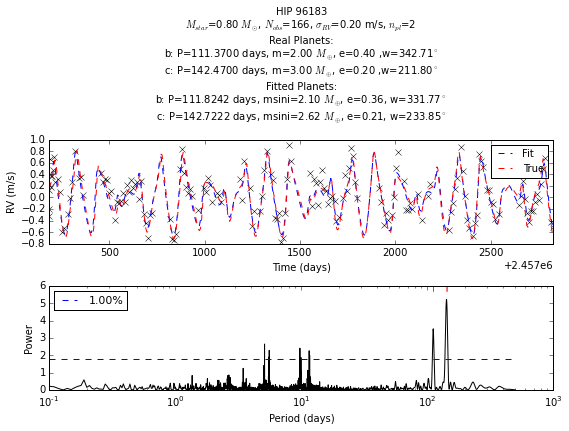

In [289]:
plt.close()
# sim1 = Simulator(50,0.05,massPlanet=5.,ecc=0.2,massStar=0.8,period=27.12453)
makePlot(sims[0])
plt.close()

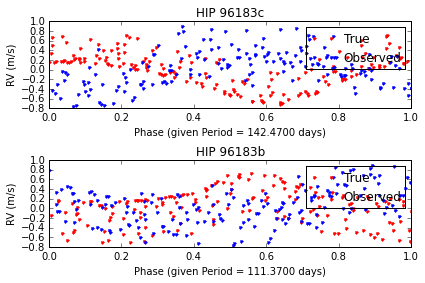

In [290]:
plt.close()
star = sims[0].star
makePhasePlot(star)
plt.close()

In [ ]:
print medianSep(sims[0].planet.obsList)

In [ ]:
#Choose what to simulate
#pickle.dump



In [ ]:
#Choose what to plot
#pickle.load
